In [ ]:
import ipywidgets as widgets
import os
import pandas as pd
import polars as pl
import numpy as np
from more_itertools import windowed


In [29]:

h = [
    "time_s",
    "time_ns",
    "frame",
    "marker1_name",
    "marker1_x",
    "marker1_y",
    "marker1_z",
    "marker1_visible",
    "marker2_name",
    "marker2_x",
    "marker2_y",
    "marker2_z",
    "marker2_visible",
    "marker3_name",
    "marker3_x",
    "marker3_y",
    "marker3_z",
    "marker3_visible",
    "rb_name", 
    "rb_id", 
    "rb_parentId", 
    "rb_x", 
    "rb_y", 
    "rb_z", 
    "rb_q1",
    "rb_q2",
    "rb_q3", 
    "rb_q4",
    "rb_trackingValid",
    "rb_meanError"
]

data = pd.read_csv("20250317T1431_big_stick_obstacle_moved.csv", names=h, index_col=False)
data = pl.from_dataframe(data)



/tmp/ipykernel_993410/3968568064.py:34: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data = pd.read_csv("20250317T1431_big_stick_obstacle_moved.csv", names=h, index_col=False)


In [40]:
valid_points = data.filter(pl.col("rb_trackingValid")).select(["rb_x", "rb_y", "rb_z"])
# find geom_center
geom_center_z = valid_points.select("rb_z").mean().item()
geom_center = [0, 0, geom_center_z]

# calculate vectors to the center for each.

valid_points = valid_points.with_columns(
    pl.concat_list(
        [
            (geom_center[0] - pl.col("rb_x")).alias("dist_x"),
            (geom_center[1] - pl.col("rb_y")).alias("dist_y"),
            (geom_center[2] - pl.col("rb_z")).alias("dist_z"),
        ]
    ).alias("vec_to_point")
)

valid_points = valid_points.with_columns(
    pl.col("vec_to_point").list.eval((pl.element().pow(2)).sum().sqrt()).list.first().alias("dist")
)


valid_points = valid_points.with_columns(
    (pl.col("vec_to_point").list[2]/pl.col("dist")).arcsin().alias("altitude")
)

valid_points = valid_points.with_columns(
    (pl.col("vec_to_point").list[0]/pl.col("dist")).arccos().alias("azimuth")
)

valid_points



shape: (27_935, 7)
┌───────────┬──────────┬──────────┬───────────────────────┬──────────┬──────────┬──────────┐
│ rb_x      ┆ rb_y     ┆ rb_z     ┆ vec_to_point          ┆ dist     ┆ altitude ┆ azimuth  │
│ ---       ┆ ---      ┆ ---      ┆ ---                   ┆ ---      ┆ ---      ┆ ---      │
│ f64       ┆ f64      ┆ f64      ┆ list[f64]             ┆ f64      ┆ f64      ┆ f64      │
╞═══════════╪══════════╪══════════╪═══════════════════════╪══════════╪══════════╪══════════╡
│ -3.303651 ┆ 2.618258 ┆ 2.732349 ┆ [3.303651, -2.618258, ┆ 4.215884 ┆ 0.015546 ┆ 0.670325 │
│           ┆          ┆          ┆ 0.065538…             ┆          ┆          ┆          │
│ -3.303647 ┆ 2.618261 ┆ 2.732344 ┆ [3.303647, -2.618261, ┆ 4.215883 ┆ 0.015547 ┆ 0.670326 │
│           ┆          ┆          ┆ 0.065543…             ┆          ┆          ┆          │
│ -3.303648 ┆ 2.618263 ┆ 2.732337 ┆ [3.303648, -2.618263, ┆ 4.215885 ┆ 0.015549 ┆ 0.670326 │
│           ┆          ┆          ┆ 0.065551…             ┆          ┆          ┆          │
│ -3.303651 ┆ 2.61826  ┆ 2.732351 ┆ [3.303651, -2.61826,  ┆ 4.215885 ┆ 0.015546 ┆ 0.670325 │
│           ┆          ┆          ┆ 0.065537]             ┆          ┆          ┆          │
│ -3.303653 ┆ 2.618266 ┆ 2.732359 ┆ [3.303653, -2.618266, ┆ 4.215891 ┆ 0.015544 ┆ 0.670326 │
│           ┆          ┆          ┆ 0.065528…             ┆          ┆          ┆          │
│ …         ┆ …        ┆ …        ┆ …                     ┆ …        ┆ …        ┆ …        │
│ -2.511452 ┆ 2.41044  ┆ 2.734873 ┆ [2.511452, -2.41044,  ┆ 3.481606 ┆ 0.0181   ┆ 0.765049 │
│           ┆          ┆          ┆ 0.063014]             ┆          ┆          ┆          │
│ -2.511452 ┆ 2.41044  ┆ 2.734873 ┆ [2.511452, -2.41044,  ┆ 3.481606 ┆ 0.0181   ┆ 0.765049 │
│           ┆          ┆          ┆ 0.063014]             ┆          ┆          ┆          │
│ -2.511203 ┆ 2.410266 ┆ 2.734866 ┆ [2.511203, -2.410266, ┆ 3.481307 ┆ 0.018104 ┆ 0.765062 │
│           ┆          ┆          ┆ 0.063022…             ┆          ┆          ┆          │
│ -2.511203 ┆ 2.410266 ┆ 2.734866 ┆ [2.511203, -2.410266, ┆ 3.481307 ┆ 0.018104 ┆ 0.765062 │
│           ┆          ┆          ┆ 0.063022…             ┆          ┆          ┆          │
│ -2.511203 ┆ 2.410266 ┆ 2.734866 ┆ [2.511203, -2.410266, ┆ 3.481307 ┆ 0.018104 ┆ 0.765062 │
│           ┆          ┆          ┆ 0.063022…             ┆          ┆          ┆          │
└───────────┴──────────┴──────────┴───────────────────────┴──────────┴──────────┴──────────┘

In [45]:
# alt/az discretization

alt_resolution = np.pi / 30
az_resolution = 2 * np.pi / 50

alt_bins = np.arange(-np.pi / 2, np.pi / 2, alt_resolution)
az_bins = np.arange(0, 2 * np.pi, az_resolution)


assert (len(alt_bins) % 2 == 0, "Number of altitude bins must be even")
assert (len(az_bins) % 2 == 0, "Number of azimuth bins must be even")


polyhedron_points = []
for az in windowed(az_bins, 2):
    for alt in windowed(alt_bins, 2):
        in_range = valid_points.filter(
            [
                (pl.col("altitude") - np.mean(alt)).abs() < alt_resolution / 2,
                (pl.col("azimuth") - np.mean(az)).abs() < az_resolution / 2,
            ]
        )

        if in_range.height > 0:
            polyhedron_point = (
                in_range.sort("dist", descending=True)
                .head(1)
                .select(["rb_x", "rb_y", "rb_z"])
                .to_numpy()
            )
            polyhedron_points.append(polyhedron_point)


print(len(polyhedron_points))

<>:10: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:11: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:10: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:11: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipykernel_993410/2639898521.py:10: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (len(alt_bins) % 2 == 0, "Number of altitude bins must be even")
/tmp/ipykernel_993410/2639898521.py:11: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (len(az_bins) % 2 == 0, "Number of azimuth bins must be even")


275


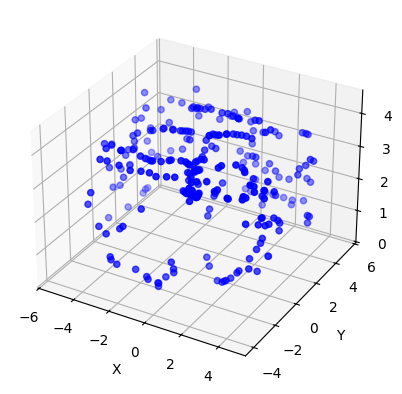

In [46]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# Extract x, y, z coordinates from polyhedron_points
x = [point[0][0] for point in polyhedron_points]
y = [point[0][1] for point in polyhedron_points]
z = [point[0][2] for point in polyhedron_points]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(x, y, z, c='b', marker='o')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [32]:

# # make cloud centered on 0, 0, geom_center_z

# alpha_angle_resolution = 2*np.pi/50
# beta_angle_resolution = 2*np.pi/20

# a_plane_init_norm = np.array([0, 1, 0])
# b_plane_init_norm = np.array([0, 0, 1])

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')


# # Define a grid for the planes
# x = np.linspace(-1, 1, 10)
# y = np.linspace(-1, 1, 10)
# x, y = np.meshgrid(x, y)

# # Set labels
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# for i, alpha in enumerate(np.arange(0, 2*np.pi, alpha_angle_resolution)):
#     next_alpha = alpha + alpha_angle_resolution
#     plane1_r = R.from_quat().as_matrix() @ a_plane_init_norm
#     plane2_r = R.from_euler("xyz", [next_alpha, 0, 0]).as_matrix() @ a_plane_init_norm
#     # Plane 1
#     if i == 4:
#         z1 = (-plane1_r[0] * x - plane1_r[1] * y) * 1. / plane1_r[2]
#         ax.plot_surface(x, y, z1, alpha=0.5, color='blue', label='Plane 1')

#     # # Plane 2
#     # z2 = (-plane2_r[0] * x - plane2_r[1] * y) / plane2_r[2]
#     # ax.plot_surface(x, y, z2, alpha=0.5, color='green', label='Plane 2')


#     for beta in np.arange(0, 2*np.pi, beta_angle_resolution):
#         next_beta = beta + beta_angle_resolution
        

# plt.show()



